In [14]:
pip install torch-geometric xgboost numpy==1.26.4 pandas tqdm matplotlib basemap scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of basemap to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 112.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 165.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 138.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: basemap-data
   

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df_woa = pd.read_csv('woa_grid_shallow.csv')
df_joined = pd.read_csv('yang_woa_grid_shallow.csv')


GRID_STEP = 0.25
TOLERANCE = 0.01  # tolerancja dla dopasowania współrzędnych

# Kolejność sąsiadów: N, NE, E, SE, S, SW, W, NW
DIRECTIONS = [
    (0, GRID_STEP),
    (GRID_STEP, GRID_STEP),
    (GRID_STEP, 0),
    (GRID_STEP, -GRID_STEP),
    (0, -GRID_STEP),
    (-GRID_STEP, -GRID_STEP),
    (-GRID_STEP, 0),
    (-GRID_STEP, GRID_STEP)
]

coord_lookup = {}
for idx, row in df_woa.iterrows():
    lat_key = round(row['lat'] / TOLERANCE) * TOLERANCE
    lon_key = round(row['lon'] / TOLERANCE) * TOLERANCE
    coord_lookup[(lat_key, lon_key)] = idx

expanded_rows = []
missing_count = 0

for _, row in tqdm(df_joined.iterrows(), total=len(df_joined), desc='Znajdowanie sąsiadów'):
    base_lat = row['lat_woa']
    base_lon = row['lon_woa']

    neighbors_data = {}
    valid = True

    for dir_num, (dlat, dlon) in enumerate(DIRECTIONS, 1):
        target_lat = base_lat + dlat
        target_lon = base_lon + dlon

        lat_key = round(target_lat / TOLERANCE) * TOLERANCE
        lon_key = round(target_lon / TOLERANCE) * TOLERANCE

        if (lat_key, lon_key) in coord_lookup:
            neighbor_idx = coord_lookup[(lat_key, lon_key)]
            neighbor_row = df_woa.iloc[neighbor_idx]

            prefix = f'neigh_{dir_num}_'
            for col in neighbor_row.index:
                neighbors_data[prefix + col] = neighbor_row[col]
        else:
            valid = False
            break

    if valid:
        # połącz dane tylko jeśli znaleziono wszystkich 8 sąsiadów
        combined_row = {**row.to_dict(), **neighbors_data}
        expanded_rows.append(combined_row)
    else:
        missing_count += 1

df_result = pd.DataFrame(expanded_rows)

print(f"Znaleziono sąsiadów dla {len(df_result)} punktów ({len(df_joined)-len(df_result)} pominięto)")

Znajdowanie sąsiadów: 100%|██████████| 128559/128559 [00:58<00:00, 2198.06it/s]


Znaleziono sąsiadów dla 128508 punktów (51 pominięto)


In [2]:
df_result.columns

Index(['lat_yang', 'lon_yang', 'depth_yang', 'n2o_ppb', 'n2o_nM', 'dn2o_ppb',
       'atmPressure', 'salinity', 'lat_woa', 'lon_woa', 'temperature_00',
       'salinity_00', 'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa',
       'neigh_1_lat', 'neigh_1_lon', 'neigh_1_temperature_00',
       'neigh_1_salinity_00', 'neigh_1_oxygen_00', 'neigh_1_nitrate_00',
       'neigh_1_phosphate_00', 'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon',
       'neigh_2_temperature_00', 'neigh_2_salinity_00', 'neigh_2_oxygen_00',
       'neigh_2_nitrate_00', 'neigh_2_phosphate_00', 'neigh_2_depth',
       'neigh_3_lat', 'neigh_3_lon', 'neigh_3_temperature_00',
       'neigh_3_salinity_00', 'neigh_3_oxygen_00', 'neigh_3_nitrate_00',
       'neigh_3_phosphate_00', 'neigh_3_depth', 'neigh_4_lat', 'neigh_4_lon',
       'neigh_4_temperature_00', 'neigh_4_salinity_00', 'neigh_4_oxygen_00',
       'neigh_4_nitrate_00', 'neigh_4_phosphate_00', 'neigh_4_depth',
       'neigh_5_lat', 'neigh_5_lon', 'neigh_5_te

In [3]:
df_result = df_result.drop(['lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM', 'n2o_ppb', 'atmPressure', 'salinity'], axis=1)

In [4]:
len(df_result.columns)

73

In [5]:
df_result.columns

Index(['dn2o_ppb', 'lat_woa', 'lon_woa', 'temperature_00', 'salinity_00',
       'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa', 'neigh_1_lat',
       'neigh_1_lon', 'neigh_1_temperature_00', 'neigh_1_salinity_00',
       'neigh_1_oxygen_00', 'neigh_1_nitrate_00', 'neigh_1_phosphate_00',
       'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon', 'neigh_2_temperature_00',
       'neigh_2_salinity_00', 'neigh_2_oxygen_00', 'neigh_2_nitrate_00',
       'neigh_2_phosphate_00', 'neigh_2_depth', 'neigh_3_lat', 'neigh_3_lon',
       'neigh_3_temperature_00', 'neigh_3_salinity_00', 'neigh_3_oxygen_00',
       'neigh_3_nitrate_00', 'neigh_3_phosphate_00', 'neigh_3_depth',
       'neigh_4_lat', 'neigh_4_lon', 'neigh_4_temperature_00',
       'neigh_4_salinity_00', 'neigh_4_oxygen_00', 'neigh_4_nitrate_00',
       'neigh_4_phosphate_00', 'neigh_4_depth', 'neigh_5_lat', 'neigh_5_lon',
       'neigh_5_temperature_00', 'neigh_5_salinity_00', 'neigh_5_oxygen_00',
       'neigh_5_nitrate_00', 'neig

In [6]:
def random_geo_patches(df, lat_col='lat', lon_col='lon',
                       patch_deg=10, n_patches=40, seed=42):
    rng = np.random.RandomState(seed)

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min / patch_deg) * patch_deg,
                         np.ceil(lat_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min / patch_deg) * patch_deg,
                         np.ceil(lon_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
             lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected = []
    mask = np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (
            df[lat_col].between(la0, la1, inclusive="left") &
            df[lon_col].between(lo0, lo1, inclusive="left")
        )
        if inside.any():
            selected.append(bbox)
            mask |= inside

    return selected, mask


In [80]:
patch_list, global_test_mask = random_geo_patches(
    df_result,
    lat_col='lat_woa',
    lon_col='lon_woa',
    patch_deg=5,
    n_patches=100,
    seed=42
)

print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


Train: 119,415  |  Test: 9,093 (7.08% of total) in 100 patches


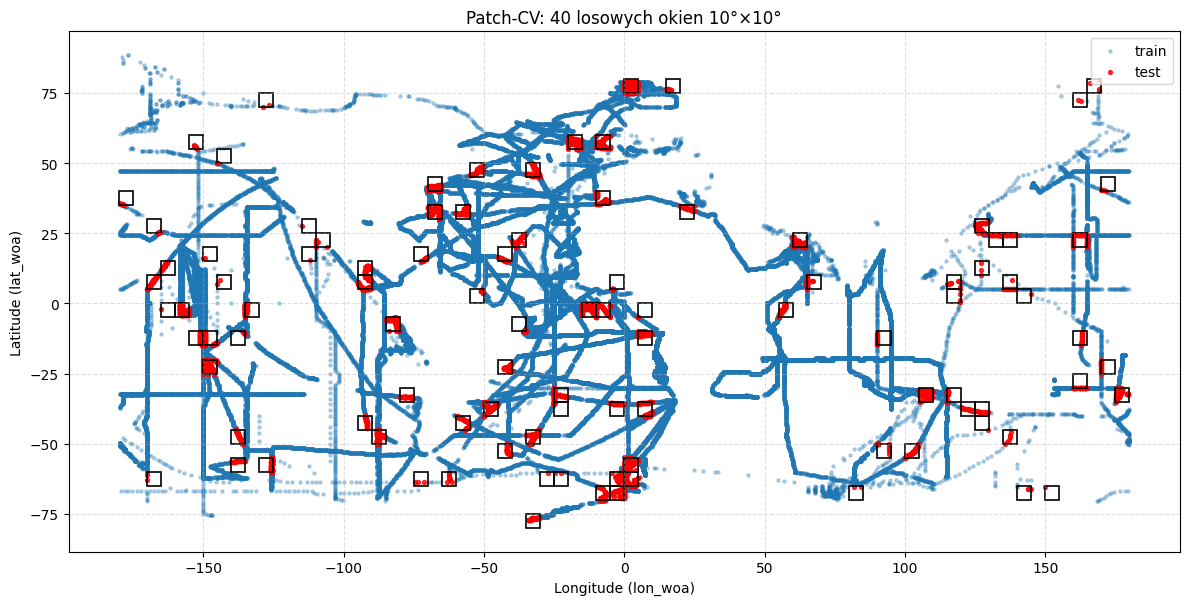

In [81]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 6))

# Punkty treningowe (nie w patchach)
ax.scatter(df_result.loc[~global_test_mask, "lon_woa"],
           df_result.loc[~global_test_mask, "lat_woa"],
           s=5, alpha=0.3, label="train")

# Punkty testowe (w patchach)
ax.scatter(df_result.loc[global_test_mask, "lon_woa"],
           df_result.loc[global_test_mask, "lat_woa"],
           s=8, alpha=0.8, color="red", label="test")

for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0),
                           lo1 - lo0,
                           la1 - la0,
                           fill=False,
                           edgecolor="black",
                           linewidth=1.2))

ax.set(title="Patch-CV: 40 losowych okien 10°×10°",
       xlabel="Longitude (lon_woa)",
       ylabel="Latitude (lat_woa)")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [82]:
df_train = df_result.loc[~global_test_mask].copy()
df_test = df_result.loc[global_test_mask].copy()


target_col = 'dn2o_ppb'

X_train = df_train.drop(columns=[target_col])
X_test = df_test.drop(columns=[target_col])
print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

Train size: 119415
Test size: 9093


In [83]:
target_col = 'dn2o_ppb'
y_train = df_train[target_col]
y_test = df_test[target_col]

In [84]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

N_JOBS = -1
SEED = 42

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")


xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

XGBoost            MSE=20610.0191 RMSE=143.5619 MAE=33.2839  R2=0.3127


In [85]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xy_train = X_train.copy()
Xy_train["target"] = y_train
Xy_train = Xy_train.dropna()

X_train_clean = Xy_train.drop("target", axis=1)
y_train_clean = Xy_train["target"]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_clean)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_clean.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

val_ratio = 0.2
n_total = len(X_tensor)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(TensorDataset(X_tensor, y_tensor), [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

class DNNRegressor(nn.Module):
    def __init__(self, input_dim):
        super(DNNRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = DNNRegressor(X_train_clean.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100
patience = 10
best_val_mse = float("inf")
epochs_no_improve = 0
best_model_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            val_preds.append(pred)
            val_targets.append(yb.numpy())

        val_preds = np.concatenate(val_preds).flatten()
        val_targets = np.concatenate(val_targets).flatten()

        val_mse = mean_squared_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_targets, val_preds)

    print(f"Epoch {epoch:03d}: TrainLoss={np.mean(train_losses):.4f} ValMSE={val_mse:.4f} RMSE={val_rmse:.4f} MAE={val_mae:.4f} R2={val_r2:.4f}")

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

model.load_state_dict(best_model_state)
model.eval()

with torch.no_grad():
    final_preds_scaled = model(X_test_tensor.to(device)).cpu().numpy()
    final_preds = target_scaler.inverse_transform(final_preds_scaled).flatten()
    y_test_true = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")

print(f"\ny_test std deviation: {y_test.std():.4f}")
evaluate("DNN Regressor", y_test_true, final_preds)


Epoch 001: TrainLoss=0.8066 ValMSE=0.5322 RMSE=0.7295 MAE=0.1133 R2=0.3408
Epoch 002: TrainLoss=0.7513 ValMSE=0.5094 RMSE=0.7138 MAE=0.1137 R2=0.3690
Epoch 003: TrainLoss=0.7240 ValMSE=0.4558 RMSE=0.6751 MAE=0.1207 R2=0.4354
Epoch 004: TrainLoss=0.7075 ValMSE=0.4650 RMSE=0.6819 MAE=0.1094 R2=0.4240
Epoch 005: TrainLoss=0.6739 ValMSE=0.4779 RMSE=0.6913 MAE=0.0992 R2=0.4080
Epoch 006: TrainLoss=0.6806 ValMSE=0.4399 RMSE=0.6632 MAE=0.0967 R2=0.4551
Epoch 007: TrainLoss=0.6880 ValMSE=0.5694 RMSE=0.7546 MAE=0.1028 R2=0.2946
Epoch 008: TrainLoss=0.7077 ValMSE=0.4745 RMSE=0.6889 MAE=0.1055 R2=0.4122
Epoch 009: TrainLoss=0.6831 ValMSE=0.4750 RMSE=0.6892 MAE=0.1016 R2=0.4116
Epoch 010: TrainLoss=0.6922 ValMSE=0.4463 RMSE=0.6681 MAE=0.1066 R2=0.4472
Epoch 011: TrainLoss=0.6855 ValMSE=0.4695 RMSE=0.6852 MAE=0.1022 R2=0.4184
Epoch 012: TrainLoss=0.6844 ValMSE=0.4520 RMSE=0.6723 MAE=0.1048 R2=0.4401
Epoch 013: TrainLoss=0.6412 ValMSE=0.4318 RMSE=0.6571 MAE=0.0934 R2=0.4651
Epoch 014: TrainLoss=0.66

# Zapisywanie datasetu (przyda się dla testowania czapeczki do regresji)

In [13]:
df_result.to_csv('yang_woa_grid_shallow_neighbors.csv', index=False)

# Dataset dla MAE - patche

In [86]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df_woa = pd.read_csv('woa_grid_shallow.csv').dropna()

GRID_STEP = 0.25
TOLERANCE = 0.001

features = [col for col in df_woa.columns]
num_features = len(features)
print(f"Znaleziono {num_features} cech w danych")

coord_dict = {}
for idx, row in tqdm(df_woa.iterrows(), total=len(df_woa), desc="Indeksowanie punktów"):
    lat_key = round(row['lat'] / TOLERANCE) * TOLERANCE
    lon_key = round(row['lon'] / TOLERANCE) * TOLERANCE
    coord_dict[(lat_key, lon_key)] = row[features].values

print("\nObliczanie unikalnych pozycji centralnych")
unique_coords = df_woa[['lat', 'lon']].drop_duplicates()
unique_coords['lat'] = round(unique_coords['lat'] / GRID_STEP) * GRID_STEP
unique_coords['lon'] = round(unique_coords['lon'] / GRID_STEP) * GRID_STEP
unique_coords = unique_coords.drop_duplicates()

print("\nGenerowanie patchy 3x3")
patches = []
valid_coords = []
missing_counts = np.zeros((3, 3))

for _, row in tqdm(unique_coords.iterrows(), total=len(unique_coords), desc="Tworzenie patchy"):
    center_lat = row['lat']
    center_lon = row['lon']

    patch_data = np.zeros((3, 3, num_features))
    valid_patch = True

    for i, dlat in enumerate([-GRID_STEP, 0, GRID_STEP]):
        for j, dlon in enumerate([-GRID_STEP, 0, GRID_STEP]):
            lat = center_lat + dlat
            lon = center_lon + dlon

            lat_key = round(lat / TOLERANCE) * TOLERANCE
            lon_key = round(lon / TOLERANCE) * TOLERANCE

            if (lat_key, lon_key) in coord_dict:
                patch_data[i, j] = coord_dict[(lat_key, lon_key)]
            else:
                missing_counts[i, j] += 1
                valid_patch = False

    if valid_patch:
        patches.append(patch_data)
        valid_coords.append((center_lat, center_lon))

patch_array = np.array(patches)
print(f"\nUtworzono {len(patches)} patchy")
print(f"Kształt danych: {patch_array.shape} (patche × 3 × 3 × cechy)")

print("\nStatystyki brakujących punktów w siatce 3x3:")
position_names = [
    ['lewy-górny', 'górny', 'prawy-górny'],
    ['lewy', 'centralny', 'prawy'],
    ['lewy-dolny', 'dolny', 'prawy-dolny']
]
for i in range(3):
    for j in range(3):
        print(f"Pozycja {position_names[i][j]}: brakuje {int(missing_counts[i,j])} punktów")

np.save('woa_3x3_patches.npy', patch_array)

coord_df = pd.DataFrame(valid_coords, columns=['center_lat', 'center_lon'])
coord_df.to_csv('patch_centers.csv', index=False)


Znaleziono 8 cech w danych


Indeksowanie punktów: 100%|██████████| 961353/961353 [03:09<00:00, 5082.07it/s]



Obliczanie unikalnych pozycji centralnych

Generowanie patchy 3x3


Tworzenie patchy: 100%|██████████| 961353/961353 [00:53<00:00, 17861.64it/s]



Utworzono 957145 patchy
Kształt danych: (957145, 3, 3, 8) (patche × 3 × 3 × cechy)

Statystyki brakujących punktów w siatce 3x3:
Pozycja lewy-górny: brakuje 2105 punktów
Pozycja górny: brakuje 1437 punktów
Pozycja prawy-górny: brakuje 2105 punktów
Pozycja lewy: brakuje 669 punktów
Pozycja centralny: brakuje 0 punktów
Pozycja prawy: brakuje 669 punktów
Pozycja lewy-dolny: brakuje 2105 punktów
Pozycja dolny: brakuje 1437 punktów
Pozycja prawy-dolny: brakuje 2105 punktów


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm
import math


patches = np.load('woa_3x3_patches.npy')  # Shape: (N, 3, 3, C)
valid = ~np.isnan(patches).any(axis=(1, 2, 3))  # Remove samples with NaNs
patches = patches[valid]


mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches = (patches - mean) / std


data_tensor = torch.tensor(patches, dtype=torch.float32)  # (N, 3, 3, C)


train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_data, val_data = random_split(data_tensor, [train_size, val_size])


train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm = nn.BatchNorm2d(channels)
        self.attn = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.norm(self.conv(x)))
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1).transpose(1, 2)  # (B, H*W, C)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        attn_out = attn_out.transpose(1, 2).view(B, C, H, W)
        return residual + attn_out

class OceanMAE(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mask_ratio = 0.4

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            ResidualAttentionBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            ResidualAttentionBlock(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, in_channels, 3, padding=1),
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        B, H, W, C = x.shape
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W)

        mask = (torch.rand(B, 1, H, W, device=x.device) > self.mask_ratio).float()
        masked_x = x * mask

        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)

        return decoded, x, mask

class MaskedMSELoss(nn.Module):
    def forward(self, pred, target, mask):
        loss = (pred - target) ** 2
        masked_loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        full_loss = loss.mean()
        return masked_loss, full_loss


def train_one_epoch(model, loader, optimizer, device, scaler, epoch, total_epochs):
    model.train()
    masked_total, full_total = 0.0, 0.0
    for batch in tqdm(loader, desc="Train", leave=False):
        inputs = batch.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            pred, target, mask = model(inputs)
            masked_loss, full_loss = criterion(pred, target, mask)
            alpha = max(0.1 * (1 - epoch / total_epochs), 0.01)
            loss = masked_loss + alpha * full_loss

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        masked_total += masked_loss.item()
        full_total += full_loss.item()

    return masked_total / len(loader), full_total / len(loader)

def validate(model, loader, device):
    model.eval()
    masked_total, full_total = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Valid", leave=False):
            inputs = batch.to(device)
            pred, target, mask = model(inputs)
            masked_loss, full_loss = criterion(pred, target, mask)
            masked_total += masked_loss.item()
            full_total += full_loss.item()

    return masked_total / len(loader), full_total / len(loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
criterion = MaskedMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.cuda.amp.GradScaler()

best_val = float('inf')
patience, no_improve = 10, 0
epochs = 50


print("Starting training...")
for epoch in range(epochs):

    model.mask_ratio = 0.3 + 0.3 * 0.5 * (1 - math.cos(math.pi * (epoch % 10) / 10))

    train_m, train_f = train_one_epoch(model, train_loader, optimizer, device, scaler, epoch, epochs)
    val_m, val_f = validate(model, val_loader, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}/{epochs}:")
    print(f"  Train - Masked Loss: {train_m:.5f} | Full Loss: {train_f:.5f}")
    print(f"  Val   - Masked Loss: {val_m:.5f} | Full Loss: {val_f:.5f}")
    print(f"  Mask Ratio: {model.mask_ratio:.2f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 60)

    if val_f < best_val:
        best_val = val_f
        no_improve = 0
        torch.save(model.state_dict(), "best_ocean_mae.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("Loading best model and saving final weights...")
model.load_state_dict(torch.load("best_ocean_mae.pth"))
torch.save(model.state_dict(), "final_ocean_mae.pth")
print("Done.")


Starting training...


Epoch 001/50:
  Train - Masked Loss: 0.18747 | Full Loss: 0.02413
  Val   - Masked Loss: 0.02692 | Full Loss: 0.00371
  Mask Ratio: 0.30 | LR: 5.00e-04
------------------------------------------------------------


Epoch 002/50:
  Train - Masked Loss: 0.02073 | Full Loss: 0.00292
  Val   - Masked Loss: 0.01514 | Full Loss: 0.00215
  Mask Ratio: 0.31 | LR: 4.98e-04
------------------------------------------------------------


Epoch 003/50:
  Train - Masked Loss: 0.01346 | Full Loss: 0.00200
  Val   - Masked Loss: 0.01091 | Full Loss: 0.00170
  Mask Ratio: 0.33 | LR: 4.96e-04
------------------------------------------------------------


Epoch 004/50:
  Train - Masked Loss: 0.01102 | Full Loss: 0.00178
  Val   - Masked Loss: 0.01054 | Full Loss: 0.00155
  Mask Ratio: 0.36 | LR: 4.92e-04
------------------------------------------------------------


Epoch 005/50:
  Train - Masked Loss: 0.00941 | Full Loss: 0.00177
  Val   - Masked Loss: 0.01046 | Full Loss: 0.00188
  Mask Ratio: 0.40 | LR: 4.88e-04
------------------------------------------------------------


Epoch 006/50:
  Train - Masked Loss: 0.00858 | Full Loss: 0.00212
  Val   - Masked Loss: 0.00740 | Full Loss: 0.00175
  Mask Ratio: 0.45 | LR: 4.82e-04
------------------------------------------------------------


Epoch 007/50:
  Train - Masked Loss: 0.00968 | Full Loss: 0.00331
  Val   - Masked Loss: 0.00803 | Full Loss: 0.00285
  Mask Ratio: 0.50 | LR: 4.76e-04
------------------------------------------------------------


Epoch 008/50:
  Train - Masked Loss: 0.00848 | Full Loss: 0.00499
  Val   - Masked Loss: 0.00773 | Full Loss: 0.00497
  Mask Ratio: 0.54 | LR: 4.69e-04
------------------------------------------------------------


Epoch 009/50:
  Train - Masked Loss: 0.00893 | Full Loss: 0.00731
  Val   - Masked Loss: 0.01016 | Full Loss: 0.00748
  Mask Ratio: 0.57 | LR: 4.61e-04
------------------------------------------------------------


Epoch 010/50:
  Train - Masked Loss: 0.00777 | Full Loss: 0.00953
  Val   - Masked Loss: 0.00881 | Full Loss: 0.00909
  Mask Ratio: 0.59 | LR: 4.52e-04
------------------------------------------------------------


Epoch 011/50:
  Train - Masked Loss: 0.00740 | Full Loss: 0.00106
  Val   - Masked Loss: 0.00644 | Full Loss: 0.00096
  Mask Ratio: 0.30 | LR: 4.43e-04
------------------------------------------------------------


Epoch 012/50:
  Train - Masked Loss: 0.00525 | Full Loss: 0.00080
  Val   - Masked Loss: 0.00469 | Full Loss: 0.00074
  Mask Ratio: 0.31 | LR: 4.32e-04
------------------------------------------------------------


Epoch 013/50:
  Train - Masked Loss: 0.00489 | Full Loss: 0.00079
  Val   - Masked Loss: 0.00448 | Full Loss: 0.00078
  Mask Ratio: 0.33 | LR: 4.21e-04
------------------------------------------------------------


Epoch 014/50:
  Train - Masked Loss: 0.00510 | Full Loss: 0.00090
  Val   - Masked Loss: 0.00472 | Full Loss: 0.00082
  Mask Ratio: 0.36 | LR: 4.09e-04
------------------------------------------------------------


Epoch 015/50:
  Train - Masked Loss: 0.00512 | Full Loss: 0.00110
  Val   - Masked Loss: 0.00562 | Full Loss: 0.00118
  Mask Ratio: 0.40 | LR: 3.97e-04
------------------------------------------------------------


Epoch 016/50:
  Train - Masked Loss: 0.00512 | Full Loss: 0.00156
  Val   - Masked Loss: 0.00455 | Full Loss: 0.00145
  Mask Ratio: 0.45 | LR: 3.84e-04
------------------------------------------------------------


Epoch 017/50:
  Train - Masked Loss: 0.00529 | Full Loss: 0.00265
  Val   - Masked Loss: 0.00559 | Full Loss: 0.00259
  Mask Ratio: 0.50 | LR: 3.70e-04
------------------------------------------------------------


Epoch 018/50:
  Train - Masked Loss: 0.00506 | Full Loss: 0.00445
  Val   - Masked Loss: 0.00514 | Full Loss: 0.00415
  Mask Ratio: 0.54 | LR: 3.56e-04
------------------------------------------------------------


Epoch 019/50:
  Train - Masked Loss: 0.00538 | Full Loss: 0.00683
  Val   - Masked Loss: 0.00590 | Full Loss: 0.00749
  Mask Ratio: 0.57 | LR: 3.42e-04
------------------------------------------------------------


Epoch 020/50:
  Train - Masked Loss: 0.00524 | Full Loss: 0.00897
  Val   - Masked Loss: 0.00471 | Full Loss: 0.00895
  Mask Ratio: 0.59 | LR: 3.27e-04
------------------------------------------------------------


Epoch 021/50:
  Train - Masked Loss: 0.00530 | Full Loss: 0.00080
  Val   - Masked Loss: 0.00461 | Full Loss: 0.00073
  Mask Ratio: 0.30 | LR: 3.12e-04
------------------------------------------------------------


Epoch 022/50:
  Train - Masked Loss: 0.00395 | Full Loss: 0.00064
  Val   - Masked Loss: 0.00350 | Full Loss: 0.00054
  Mask Ratio: 0.31 | LR: 2.97e-04
------------------------------------------------------------


Epoch 023/50:
  Train - Masked Loss: 0.00373 | Full Loss: 0.00065
  Val   - Masked Loss: 0.00337 | Full Loss: 0.00057
  Mask Ratio: 0.33 | LR: 2.81e-04
------------------------------------------------------------


Epoch 024/50:
  Train - Masked Loss: 0.00361 | Full Loss: 0.00074
  Val   - Masked Loss: 0.00324 | Full Loss: 0.00065
  Mask Ratio: 0.36 | LR: 2.66e-04
------------------------------------------------------------


Epoch 025/50:
  Train - Masked Loss: 0.00370 | Full Loss: 0.00091
  Val   - Masked Loss: 0.00382 | Full Loss: 0.00101
  Mask Ratio: 0.40 | LR: 2.50e-04
------------------------------------------------------------


Epoch 026/50:
  Train - Masked Loss: 0.00377 | Full Loss: 0.00134
  Val   - Masked Loss: 0.00350 | Full Loss: 0.00143
  Mask Ratio: 0.45 | LR: 2.34e-04
------------------------------------------------------------


Epoch 027/50:
  Train - Masked Loss: 0.00390 | Full Loss: 0.00239
  Val   - Masked Loss: 0.00363 | Full Loss: 0.00220
  Mask Ratio: 0.50 | LR: 2.19e-04
------------------------------------------------------------


Epoch 028/50:
  Train - Masked Loss: 0.00397 | Full Loss: 0.00432
  Val   - Masked Loss: 0.00353 | Full Loss: 0.00413
  Mask Ratio: 0.54 | LR: 2.03e-04
------------------------------------------------------------


Epoch 029/50:
  Train - Masked Loss: 0.00402 | Full Loss: 0.00671
  Val   - Masked Loss: 0.00401 | Full Loss: 0.00672
  Mask Ratio: 0.57 | LR: 1.88e-04
------------------------------------------------------------


Epoch 030/50:
  Train - Masked Loss: 0.00399 | Full Loss: 0.00904
  Val   - Masked Loss: 0.00353 | Full Loss: 0.00870
  Mask Ratio: 0.59 | LR: 1.73e-04
------------------------------------------------------------


Epoch 031/50:
  Train - Masked Loss: 0.00426 | Full Loss: 0.00066
  Val   - Masked Loss: 0.00363 | Full Loss: 0.00057
  Mask Ratio: 0.30 | LR: 1.58e-04
------------------------------------------------------------


Epoch 032/50:
  Train - Masked Loss: 0.00324 | Full Loss: 0.00055
  Val   - Masked Loss: 0.00298 | Full Loss: 0.00050
  Mask Ratio: 0.31 | LR: 1.44e-04
------------------------------------------------------------


Epoch 033/50:
  Train - Masked Loss: 0.00315 | Full Loss: 0.00057
  Val   - Masked Loss: 0.00285 | Full Loss: 0.00056
  Mask Ratio: 0.33 | LR: 1.30e-04
------------------------------------------------------------


Epoch 034/50:
  Train - Masked Loss: 0.00311 | Full Loss: 0.00064
  Val   - Masked Loss: 0.00299 | Full Loss: 0.00062
  Mask Ratio: 0.36 | LR: 1.16e-04
------------------------------------------------------------


Epoch 035/50:
  Train - Masked Loss: 0.00315 | Full Loss: 0.00091
  Val   - Masked Loss: 0.00307 | Full Loss: 0.00088
  Mask Ratio: 0.40 | LR: 1.03e-04
------------------------------------------------------------


Epoch 036/50:
  Train - Masked Loss: 0.00328 | Full Loss: 0.00143
  Val   - Masked Loss: 0.00295 | Full Loss: 0.00123
  Mask Ratio: 0.45 | LR: 9.06e-05
------------------------------------------------------------


Epoch 037/50:
  Train - Masked Loss: 0.00339 | Full Loss: 0.00252
  Val   - Masked Loss: 0.00323 | Full Loss: 0.00240
  Mask Ratio: 0.50 | LR: 7.89e-05
------------------------------------------------------------


Epoch 038/50:
  Train - Masked Loss: 0.00344 | Full Loss: 0.00427
  Val   - Masked Loss: 0.00302 | Full Loss: 0.00446
  Mask Ratio: 0.54 | LR: 6.78e-05
------------------------------------------------------------


Epoch 039/50:
  Train - Masked Loss: 0.00355 | Full Loss: 0.00668
  Val   - Masked Loss: 0.00329 | Full Loss: 0.00671
  Mask Ratio: 0.57 | LR: 5.74e-05
------------------------------------------------------------


Epoch 040/50:
  Train - Masked Loss: 0.00357 | Full Loss: 0.00903
  Val   - Masked Loss: 0.00311 | Full Loss: 0.00912
  Mask Ratio: 0.59 | LR: 4.77e-05
------------------------------------------------------------


Epoch 041/50:
  Train - Masked Loss: 0.00387 | Full Loss: 0.00062
  Val   - Masked Loss: 0.00277 | Full Loss: 0.00050
  Mask Ratio: 0.30 | LR: 3.89e-05
------------------------------------------------------------


Epoch 042/50:
  Train - Masked Loss: 0.00287 | Full Loss: 0.00049
  Val   - Masked Loss: 0.00265 | Full Loss: 0.00047
  Mask Ratio: 0.31 | LR: 3.09e-05
------------------------------------------------------------


Epoch 043/50:
  Train - Masked Loss: 0.00285 | Full Loss: 0.00054
  Val   - Masked Loss: 0.00265 | Full Loss: 0.00050
  Mask Ratio: 0.33 | LR: 2.38e-05
------------------------------------------------------------


Epoch 044/50:
  Train - Masked Loss: 0.00287 | Full Loss: 0.00062
  Val   - Masked Loss: 0.00269 | Full Loss: 0.00064
  Mask Ratio: 0.36 | LR: 1.76e-05
------------------------------------------------------------


Epoch 045/50:
  Train - Masked Loss: 0.00294 | Full Loss: 0.00085
  Val   - Masked Loss: 0.00273 | Full Loss: 0.00083
  Mask Ratio: 0.40 | LR: 1.22e-05
------------------------------------------------------------


Epoch 046/50:
  Train - Masked Loss: 0.00310 | Full Loss: 0.00139
  Val   - Masked Loss: 0.00283 | Full Loss: 0.00149
  Mask Ratio: 0.45 | LR: 7.85e-06
------------------------------------------------------------


Epoch 047/50:
  Train - Masked Loss: 0.00328 | Full Loss: 0.00250
  Val   - Masked Loss: 0.00295 | Full Loss: 0.00234
  Mask Ratio: 0.50 | LR: 4.43e-06
------------------------------------------------------------


Epoch 048/50:
  Train - Masked Loss: 0.00349 | Full Loss: 0.00420
  Val   - Masked Loss: 0.00309 | Full Loss: 0.00406
  Mask Ratio: 0.54 | LR: 1.97e-06
------------------------------------------------------------


Epoch 049/50:
  Train - Masked Loss: 0.00367 | Full Loss: 0.00701
  Val   - Masked Loss: 0.00327 | Full Loss: 0.00654
  Mask Ratio: 0.57 | LR: 4.93e-07
------------------------------------------------------------


Epoch 050/50:
  Train - Masked Loss: 0.00397 | Full Loss: 0.00929
  Val   - Masked Loss: 0.00356 | Full Loss: 0.00927
  Mask Ratio: 0.59 | LR: 0.00e+00
------------------------------------------------------------
Loading best model and saving final weights...
Done.


Index(['dn2o_ppb', 'lat_woa', 'lon_woa', 'temperature_00', 'salinity_00',
       'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa', 'neigh_1_lat',
       'neigh_1_lon', 'neigh_1_temperature_00', 'neigh_1_salinity_00',
       'neigh_1_oxygen_00', 'neigh_1_nitrate_00', 'neigh_1_phosphate_00',
       'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon', 'neigh_2_temperature_00',
       'neigh_2_salinity_00', 'neigh_2_oxygen_00', 'neigh_2_nitrate_00',
       'neigh_2_phosphate_00', 'neigh_2_depth', 'neigh_3_lat', 'neigh_3_lon',
       'neigh_3_temperature_00', 'neigh_3_salinity_00', 'neigh_3_oxygen_00',
       'neigh_3_nitrate_00', 'neigh_3_phosphate_00', 'neigh_3_depth',
       'neigh_4_lat', 'neigh_4_lon', 'neigh_4_temperature_00',
       'neigh_4_salinity_00', 'neigh_4_oxygen_00', 'neigh_4_nitrate_00',
       'neigh_4_phosphate_00', 'neigh_4_depth', 'neigh_5_lat', 'neigh_5_lon',
       'neigh_5_temperature_00', 'neigh_5_salinity_00', 'neigh_5_oxygen_00',
       'neigh_5_nitrate_00', 'neig

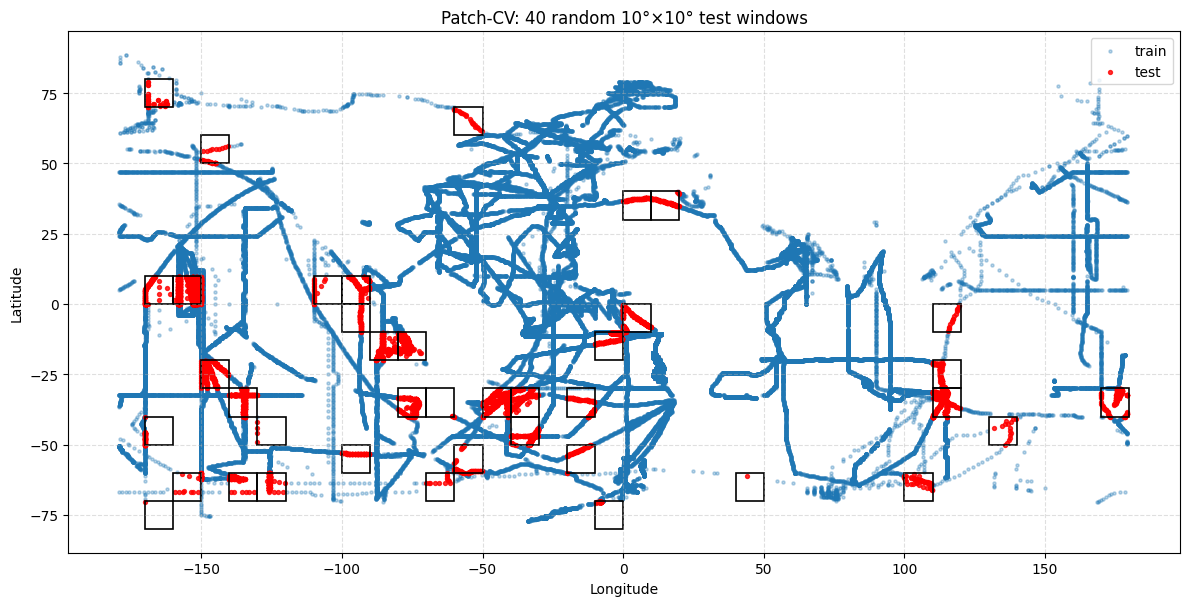

Creating patches: 100%|██████████| 128299/128299 [03:46<00:00, 566.49it/s]


Patches shape: (128299, 3, 3, 8)


In [101]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def random_geo_patches(df, lat_col='lat', lon_col='lon',
                       patch_deg=10, n_patches=40, seed=42):
    rng = np.random.RandomState(seed)

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min / patch_deg) * patch_deg,
                         np.ceil(lat_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min / patch_deg) * patch_deg,
                         np.ceil(lon_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
             lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected = []
    mask = np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (
            df[lat_col].between(la0, la1, inclusive="left") &
            df[lon_col].between(lo0, lo1, inclusive="left")
        )
        if inside.any():
            selected.append(bbox)
            mask |= inside

    return selected, mask

def stratified_geo_patches(df, 
                           lat_col='lat', lon_col='lon', target_col='dn2o_ppb',
                           patch_deg=10, n_patches=40,
                           n_strata=5,         # ile koszyków targetu
                           seed=42):
    """
    Wybiera n_patches komórek o rozmiarze patch_deg×patch_deg stopni,
    tak by rozkład targetu w wybranych komórkach odzwierciedlał rozkład globalny.
    """
    rng = np.random.RandomState(seed)

    # 1) Zbuduj grid komórek
    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min/patch_deg)*patch_deg,
                         np.ceil(lat_max/patch_deg)*patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min/patch_deg)*patch_deg,
                         np.ceil(lon_max/patch_deg)*patch_deg + patch_deg,
                         patch_deg)

    cells = []
    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            la0, la1 = lat_bins[i], lat_bins[i+1]
            lo0, lo1 = lon_bins[j], lon_bins[j+1]
            mask = (df[lat_col].between(la0, la1, inclusive='left') &
                    df[lon_col].between(lo0, lo1, inclusive='left'))
            if mask.any():
                med = df.loc[mask, target_col].median()
                cells.append({
                    'bbox': (la0, la1, lo0, lo1),
                    'mask' : mask.values,
                    'median': med
                })

    cells_df = pd.DataFrame(cells)
    # 2) Zdefiniuj koszyki po medianie targetu
    #    np.linspace od min do max mediany dzieli na n_strata
    bins = np.quantile(cells_df['median'], 
                       np.linspace(0,1,n_strata+1))
    # przypisz każdy cell do koszyka 0..n_strata-1
    cells_df['stratum'] = np.digitize(cells_df['median'], bins) - 1
    # boundary fix
    cells_df['stratum'] = cells_df['stratum'].clip(0, n_strata-1)

    # 3) Dla każdego koszyka weź proporcjonalnie liczbę patchy
    counts = cells_df['stratum'].value_counts().sort_index()
    # ile z n_patches w każdym stratum
    frac = counts / counts.sum()
    to_draw = np.floor(frac * n_patches).astype(int)

    # skoryguj, żeby suma == n_patches
    diff = n_patches - to_draw.sum()
    if diff>0:
        # dorzuć po jednym do największych frakcji
        for idx in np.argsort(-frac.values)[:diff]:
            to_draw.iloc[idx] += 1

    # 4) Losujemy
    selected_cells = []
    final_mask = np.zeros(len(df), dtype=bool)
    for stratum, k in to_draw.items():
        pool = cells_df[cells_df['stratum']==stratum]
        chosen = pool.sample(n=k, random_state=seed)['bbox'].tolist()
        selected_cells += chosen
        # OR mask na wszystkie samples w tym stratum
        for bbox in chosen:
            la0, la1, lo0, lo1 = bbox
            final_mask |= ((df[lat_col].between(la0, la1, inclusive='left')) &
                           (df[lon_col].between(lo0, lo1, inclusive='left')))

    return selected_cells, final_mask


df = pd.read_csv('yang_woa_grid_shallow_neighbors.csv').dropna()
print(df.columns)

lat_min, lat_max = df['lat_woa'].min(), df['lat_woa'].max()
lon_min, lon_max = df['lon_woa'].min(), df['lon_woa'].max()

# Center lat/lon
#df['lat'] = (df['lat_woa'] - lat_min) / (lat_max - lat_min)
#df['lon'] = (df['lon_woa'] - lon_min) / (lon_max - lon_min)
df['lat'] = df['lat_woa']
df['lon'] = df['lon_woa']
# Normalize neighbor lat/lon similarly
#for i in range(1, 9):
#    df[f'neigh_{i}_lat'] = (df[f'neigh_{i}_lat'] - lat_min) / (lat_max - lat_min)
#    df[f'neigh_{i}_lon'] = (df[f'neigh_{i}_lon'] - lon_min) / (lon_max - lon_min)


for i in range(1, 9):
    df[f'neigh_{i}_lat'] = df[f'neigh_{i}_lat'] - lat_min
    df[f'neigh_{i}_lon'] = df[f'neigh_{i}_lon'] - lon_min


patch_list, global_test_mask = stratified_geo_patches(
    df, lat_col='lat_woa', lon_col='lon_woa', patch_deg=10, n_patches=40, seed=42
)
print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.loc[~global_test_mask, "lon_woa"], df.loc[~global_test_mask, "lat_woa"],
           s=5, alpha=0.3, label="train")
ax.scatter(df.loc[global_test_mask, "lon_woa"], df.loc[global_test_mask, "lat_woa"],
           s=8, alpha=0.8, color="red", label="test")
for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0), lo1 - lo0, la1 - la0,
                           fill=False, edgecolor="black", linewidth=1.2))
ax.set(title="Patch-CV: 40 random 10°×10° test windows",
       xlabel="Longitude", ylabel="Latitude")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


base_cols = ['lat', 'lon', 'temperature_00', 'salinity_00', 'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth']
prefix_order = [
    'neigh_1_', 'neigh_2_', 'neigh_3_',
    'neigh_4_', '',         'neigh_5_',
    'neigh_6_', 'neigh_7_', 'neigh_8_'
]

neigh_cols = []
for prefix in prefix_order:
    if prefix == '':
        cols = [col if col != 'depth' else 'depth_woa' for col in base_cols]
    else:
        cols = [f'{prefix}{col}' for col in base_cols]
    neigh_cols.append(cols)


patches = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating patches"):
    patch = np.zeros((3, 3, len(base_cols)))
    for i in range(9):
        r, c = divmod(i, 3)
        patch[r, c] = row[neigh_cols[i]]
    patches.append(patch)
patches = np.array(patches)
print(f"Patches shape: {patches.shape}")  # Should be (N, 3, 3, 8)

# === Normalize patches using training stats ===
#train_patches = np.load('woa_3x3_patches.npy')
#mean = train_patches.mean(axis=(0,1,2), keepdims=True)
#std = train_patches.std(axis=(0,1,2), keepdims=True) + 1e-8
#patches_norm = (patches - mean) / std

mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches_norm = (patches - mean) / std


In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = OceanMAE(in_channels=patches_norm.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

raw_targets_np = df['dn2o_ppb'].values
global_test_mask_np = global_test_mask.values
valid_mask = (~np.isnan(raw_targets_np)) & (raw_targets_np >= 0)

filtered_patches_norm = patches_norm[valid_mask]
filtered_targets = raw_targets_np[valid_mask]
filtered_global_test_mask = global_test_mask_np[valid_mask]

with torch.no_grad():
    x = torch.tensor(filtered_patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)  # from (N, H, W, C) to (N, C, H, W)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

embeddings_np = embeddings.numpy()

# 4. Log scale the targets (log1p)
targets_np = np.log1p(filtered_targets)

embeddings_filtered = torch.tensor(embeddings_np, dtype=torch.float32)
targets_filtered = torch.tensor(targets_np, dtype=torch.float32).unsqueeze(1)

X_train = embeddings_filtered[~filtered_global_test_mask]
y_train = targets_filtered[~filtered_global_test_mask]
X_test = embeddings_filtered[filtered_global_test_mask]
y_test = targets_filtered[filtered_global_test_mask]

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train), [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(9):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    # Inverse transform predictions and true values back to original scale
    val_true_orig = np.expm1(val_true)
    val_pred_orig = np.expm1(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)  # RMSE
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE (orig scale): {val_rmse_orig:.4f}, R² (orig scale): {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

# Inverse transform predictions and true values back to original scale
y_true_orig = np.expm1(y_true)
y_pred_orig = np.expm1(y_pred)

print(f"Test R² (orig scale): {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE (orig scale): {mean_squared_error(y_true_orig, y_pred_orig):.4f}")



Training regressor...


Epoch 001 - Train Loss: 1.0750 | Val RMSE (orig scale): 12013.5400, R² (orig scale): 0.5433


Epoch 002 - Train Loss: 0.5305 | Val RMSE (orig scale): 9256.6738, R² (orig scale): 0.6481


Epoch 003 - Train Loss: 0.4798 | Val RMSE (orig scale): 13734.3203, R² (orig scale): 0.4779


Epoch 004 - Train Loss: 0.4552 | Val RMSE (orig scale): 10494.6592, R² (orig scale): 0.6010


Epoch 005 - Train Loss: 0.4360 | Val RMSE (orig scale): 11771.4775, R² (orig scale): 0.5525


Epoch 006 - Train Loss: 0.4236 | Val RMSE (orig scale): 11024.4600, R² (orig scale): 0.5809


Epoch 007 - Train Loss: 0.4139 | Val RMSE (orig scale): 12084.8428, R² (orig scale): 0.5406


Epoch 008 - Train Loss: 0.4050 | Val RMSE (orig scale): 10953.3848, R² (orig scale): 0.5836
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 009 - Train Loss: 0.3835 | Val RMSE (orig scale): 7972.5444, R² (orig scale): 0.6969

Final evaluation on test set:
Test R² (orig scale): -0.3481
Test RMSE (orig scale): 1907015.1250


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

with torch.no_grad():
    x = torch.tensor(patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

targets = torch.tensor(df['dn2o_ppb'].values, dtype=torch.float32).unsqueeze(1)

embeddings_np = embeddings.numpy()
targets_np = targets.numpy().squeeze()

not_nan_mask = (~np.isnan(embeddings_np).any(axis=1)) & (~np.isnan(targets_np))
embeddings_np = embeddings_np[not_nan_mask]
targets_np = targets_np[not_nan_mask]
global_test_mask_np = global_test_mask.values[not_nan_mask]

# Clip train/val targets to roughly match test range (CHEATING!!!! just for checking)
clip_min, clip_max = -150, 400

embeddings_filtered = torch.tensor(embeddings_np)
targets_filtered = torch.tensor(targets_np).unsqueeze(1)

X_train = embeddings_filtered[~global_test_mask_np]
y_train = targets_filtered[~global_test_mask_np]
X_test = embeddings_filtered[global_test_mask_np]
y_test = targets_filtered[global_test_mask_np]


y_train_clipped = torch.clamp(y_train, clip_min, clip_max)

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train_clipped), [train_size, val_size])


batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

train_val_targets = torch.cat([y for _, y in train_ds] + [y for _, y in val_ds]).numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(train_val_targets)

def scale_targets(tensor):
    t_np = tensor.numpy().reshape(-1, 1)
    t_scaled = scaler.transform(t_np)
    return torch.tensor(t_scaled, dtype=torch.float32)

def inverse_scale_targets(np_array):
    return scaler.inverse_transform(np_array.reshape(-1,1)).flatten()


def scale_dataset(ds):
    xs = []
    ys = []
    for x, y in ds:
        xs.append(x)
        ys.append(y)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    ys_scaled = scale_targets(ys)
    return TensorDataset(xs, ys_scaled)

train_ds = scale_dataset(train_ds)
val_ds = scale_dataset(val_ds)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
y_test_scaled = scale_targets(y_test)
test_loader = DataLoader(TensorDataset(X_test, y_test_scaled), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(20):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    # inverse scale val predictions and true values
    val_true_orig = inverse_scale_targets(val_true)
    val_pred_orig = inverse_scale_targets(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

y_true_orig = inverse_scale_targets(y_true)
y_pred_orig = inverse_scale_targets(y_pred)

print(f"Test R²: {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE: {mean_squared_error(y_true_orig, y_pred_orig):.4f}")



Training regressor...


Epoch 001 - Train Loss: 0.4117 | Val RMSE: 1511.4108, R²: 0.7725


Epoch 002 - Train Loss: 0.2460 | Val RMSE: 1337.2782, R²: 0.7987


Epoch 003 - Train Loss: 0.2161 | Val RMSE: 964.9186, R²: 0.8548


Epoch 004 - Train Loss: 0.1985 | Val RMSE: 1077.3353, R²: 0.8379


Epoch 005 - Train Loss: 0.1861 | Val RMSE: 985.3714, R²: 0.8517


Epoch 006 - Train Loss: 0.1800 | Val RMSE: 1137.8328, R²: 0.8288


Epoch 007 - Train Loss: 0.1718 | Val RMSE: 830.4989, R²: 0.8750


Epoch 008 - Train Loss: 0.1702 | Val RMSE: 866.9163, R²: 0.8695


Epoch 009 - Train Loss: 0.1648 | Val RMSE: 825.7713, R²: 0.8757


Epoch 010 - Train Loss: 0.1594 | Val RMSE: 824.2369, R²: 0.8759


Epoch 011 - Train Loss: 0.1582 | Val RMSE: 800.6573, R²: 0.8795


Epoch 012 - Train Loss: 0.1572 | Val RMSE: 790.1889, R²: 0.8811


Epoch 013 - Train Loss: 0.1525 | Val RMSE: 766.7358, R²: 0.8846


Epoch 014 - Train Loss: 0.1549 | Val RMSE: 829.2502, R²: 0.8752


Epoch 015 - Train Loss: 0.1489 | Val RMSE: 772.6937, R²: 0.8837


Epoch 016 - Train Loss: 0.1473 | Val RMSE: 772.4207, R²: 0.8837


Epoch 017 - Train Loss: 0.1457 | Val RMSE: 912.0960, R²: 0.8627


Epoch 018 - Train Loss: 0.1498 | Val RMSE: 799.0005, R²: 0.8797


Epoch 019 - Train Loss: 0.1404 | Val RMSE: 772.6367, R²: 0.8837


Epoch 020 - Train Loss: 0.1339 | Val RMSE: 705.9797, R²: 0.8937

Final evaluation on test set:
Test R²: 0.1144
Test RMSE: 1054993.1250


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

with torch.no_grad():
    x = torch.tensor(patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

targets = torch.tensor(df['dn2o_ppb'].values, dtype=torch.float32).unsqueeze(1)

embeddings_np = embeddings.numpy()
targets_np = targets.numpy().squeeze()

not_nan_mask = (~np.isnan(embeddings_np).any(axis=1)) & (~np.isnan(targets_np))
embeddings_np = embeddings_np[not_nan_mask]
targets_np = targets_np[not_nan_mask]
global_test_mask_np = global_test_mask.values[not_nan_mask]

embeddings_filtered = torch.tensor(embeddings_np)
targets_filtered = torch.tensor(targets_np).unsqueeze(1)

X_train = embeddings_filtered[~global_test_mask_np]
y_train = targets_filtered[~global_test_mask_np]
X_test = embeddings_filtered[global_test_mask_np]
y_test = targets_filtered[global_test_mask_np]

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train), [train_size, val_size])

batch_size = 128

# Fit scaler on train+val targets only (normalize targets)
train_val_targets = torch.cat([y for _, y in train_ds] + [y for _, y in val_ds]).numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(train_val_targets)

def scale_targets(tensor):
    t_np = tensor.numpy().reshape(-1, 1)
    t_scaled = scaler.transform(t_np)
    return torch.tensor(t_scaled, dtype=torch.float32)

def inverse_scale_targets(np_array):
    return scaler.inverse_transform(np_array.reshape(-1,1)).flatten()

def scale_dataset(ds):
    xs = []
    ys = []
    for x, y in ds:
        xs.append(x)
        ys.append(y)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    ys_scaled = scale_targets(ys)
    return TensorDataset(xs, ys_scaled)

train_ds = scale_dataset(train_ds)
val_ds = scale_dataset(val_ds)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Scale test targets with same scaler
y_test_scaled = scale_targets(y_test)
test_loader = DataLoader(TensorDataset(X_test, y_test_scaled), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(20):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    val_true_orig = inverse_scale_targets(val_true)
    val_pred_orig = inverse_scale_targets(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

y_true_orig = inverse_scale_targets(y_true)
y_pred_orig = inverse_scale_targets(y_pred)

print(f"Test R²: {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE: {mean_squared_error(y_true_orig, y_pred_orig):.4f}")



Training regressor...


Epoch 001 - Train Loss: 0.6603 | Val RMSE: 10327.4453, R²: 0.4946


Epoch 002 - Train Loss: 0.5236 | Val RMSE: 8978.6934, R²: 0.5606


Epoch 003 - Train Loss: 0.4734 | Val RMSE: 8811.6689, R²: 0.5687


Epoch 004 - Train Loss: 0.4579 | Val RMSE: 8871.0713, R²: 0.5658


Epoch 005 - Train Loss: 0.4412 | Val RMSE: 8564.9844, R²: 0.5808


Epoch 006 - Train Loss: 0.4257 | Val RMSE: 8111.8833, R²: 0.6030


Epoch 007 - Train Loss: 0.4261 | Val RMSE: 8062.2749, R²: 0.6054


Epoch 008 - Train Loss: 0.4254 | Val RMSE: 8372.0176, R²: 0.5903


Epoch 009 - Train Loss: 0.4211 | Val RMSE: 8473.9688, R²: 0.5853


Epoch 010 - Train Loss: 0.4300 | Val RMSE: 8643.6787, R²: 0.5770


Epoch 011 - Train Loss: 0.4089 | Val RMSE: 8344.6387, R²: 0.5916


Epoch 012 - Train Loss: 0.4066 | Val RMSE: 7953.1030, R²: 0.6108


Epoch 013 - Train Loss: 0.4040 | Val RMSE: 7575.5854, R²: 0.6292


Epoch 014 - Train Loss: 0.3972 | Val RMSE: 7213.6855, R²: 0.6470


Epoch 015 - Train Loss: 0.4001 | Val RMSE: 7747.3652, R²: 0.6208


Epoch 016 - Train Loss: 0.4061 | Val RMSE: 7627.3955, R²: 0.6267


Epoch 017 - Train Loss: 0.4038 | Val RMSE: 7840.4434, R²: 0.6163


Epoch 018 - Train Loss: 0.3881 | Val RMSE: 7726.4043, R²: 0.6219


Epoch 019 - Train Loss: 0.3939 | Val RMSE: 7607.2949, R²: 0.6277


Epoch 020 - Train Loss: 0.3943 | Val RMSE: 6976.9580, R²: 0.6585

Final evaluation on test set:
Test R²: 0.2678
Test RMSE: 872279.1250


Train/Val Targets:
  Mean: 47.97, Std: 139.42
  Min: -178.52, Max: 9932.15

Test Targets:
  Mean: 200.19, Std: 1091.45
  Min: -143.98, Max: 30076.24


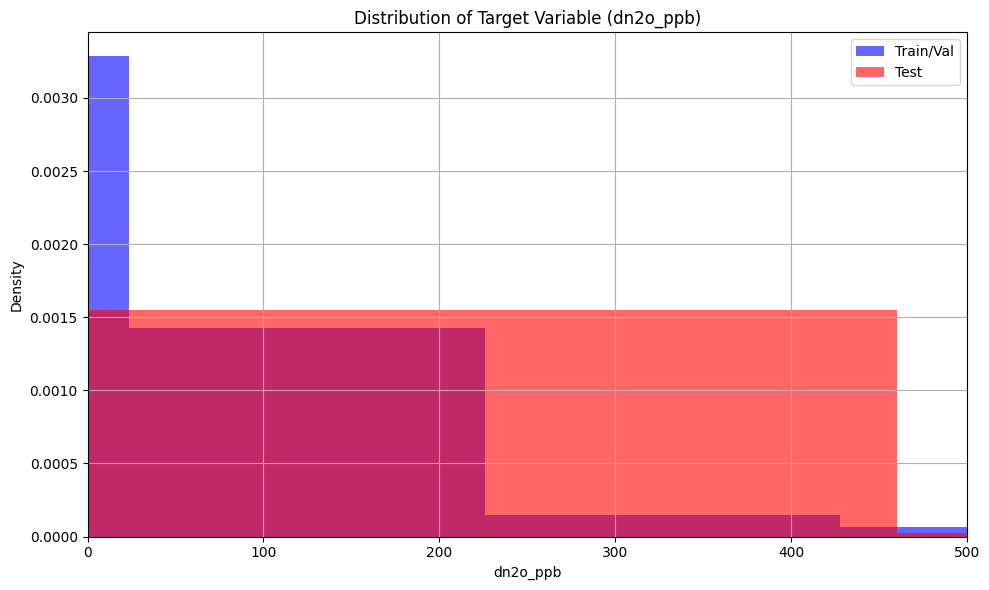

In [105]:
import matplotlib.pyplot as plt

train_val_targets = targets_np[~global_test_mask_np]
test_targets = targets_np[global_test_mask_np]

print("Train/Val Targets:")
print(f"  Mean: {train_val_targets.mean():.2f}, Std: {train_val_targets.std():.2f}")
print(f"  Min: {train_val_targets.min():.2f}, Max: {train_val_targets.max():.2f}")

print("\nTest Targets:")
print(f"  Mean: {test_targets.mean():.2f}, Std: {test_targets.std():.2f}")
print(f"  Min: {test_targets.min():.2f}, Max: {test_targets.max():.2f}")


plt.figure(figsize=(10, 6))
plt.hist(train_val_targets, bins=50, alpha=0.6, label='Train/Val', color='blue', density=True)
plt.hist(test_targets, bins=50, alpha=0.6, label='Test', color='red', density=True)
plt.xlim(0, 500)
plt.xlabel('dn2o_ppb')
plt.ylabel('Density')
plt.title('Distribution of Target Variable (dn2o_ppb)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


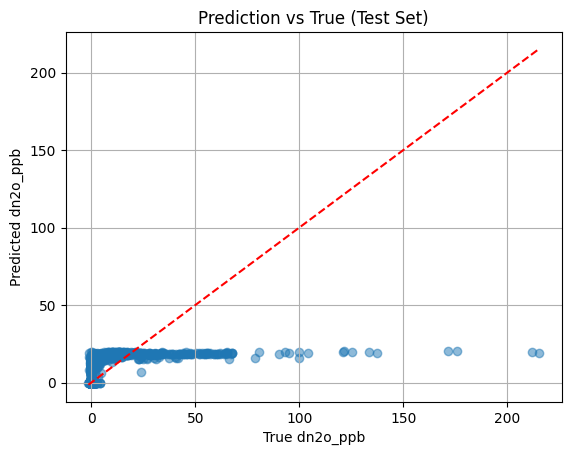

In [106]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True dn2o_ppb')
plt.ylabel('Predicted dn2o_ppb')
plt.title('Prediction vs True (Test Set)')
plt.grid(True)
plt.show()


inny encoder, inny regresor

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm


patches = np.load('woa_3x3_patches.npy')  # (N, 3, 3, C)
valid = ~np.isnan(patches).any(axis=(1, 2, 3))
patches = patches[valid]

mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches = (patches - mean) / std


center_pixel = patches[:, 1, 1, :]  # (N, C)
context = np.delete(patches.reshape(len(patches), 3*3, -1), 4, axis=1)  # usuń środek (N, 8, C)


X = torch.tensor(context, dtype=torch.float32)  # (N, 8, C)
y = torch.tensor(center_pixel, dtype=torch.float32)  # (N, C)


dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)


class ReprNet(nn.Module):
    def __init__(self, in_channels, repr_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),  # (8, C) → (8*C,)
            nn.Linear(8 * in_channels, 256),
            nn.ReLU(),
            nn.Linear(256, repr_dim),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(repr_dim, in_channels)  # output: (C,)

    def forward(self, x):
        z = self.encoder(x)
        out = self.regressor(z)
        return out, z


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in tqdm(loader, desc="Train", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for x_batch, y_batch in tqdm(loader, desc="Valid", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred, _ = model(x_batch)
        loss = criterion(pred, y_batch)
        total_loss += loss.item()
    return total_loss / len(loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReprNet(in_channels=y.shape[1], repr_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

best_val = float('inf')
patience, no_improve = 10, 0
epochs = 50

print("Training for representation learning...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    if val_loss < best_val:
        best_val = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_reprnet.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

print("Saving final model...")
model.load_state_dict(torch.load("best_reprnet.pth"))
torch.save(model.state_dict(), "final_reprnet.pth")
print("Done.")


Training for representation learning...


Epoch 001/50 | Train Loss: 0.00566 | Val Loss: 0.00006


Epoch 002/50 | Train Loss: 0.00007 | Val Loss: 0.00006


Epoch 003/50 | Train Loss: 0.00007 | Val Loss: 0.00004


Epoch 004/50 | Train Loss: 0.00006 | Val Loss: 0.00017


Epoch 005/50 | Train Loss: 0.00006 | Val Loss: 0.00005


Epoch 006/50 | Train Loss: 0.00006 | Val Loss: 0.00006


Epoch 007/50 | Train Loss: 0.00005 | Val Loss: 0.00005


Epoch 008/50 | Train Loss: 0.00005 | Val Loss: 0.00004


Epoch 009/50 | Train Loss: 0.00004 | Val Loss: 0.00005


Epoch 010/50 | Train Loss: 0.00004 | Val Loss: 0.00004


Epoch 011/50 | Train Loss: 0.00004 | Val Loss: 0.00003


Epoch 012/50 | Train Loss: 0.00003 | Val Loss: 0.00003


Epoch 013/50 | Train Loss: 0.00003 | Val Loss: 0.00004


Epoch 014/50 | Train Loss: 0.00003 | Val Loss: 0.00003


Epoch 015/50 | Train Loss: 0.00003 | Val Loss: 0.00003


Epoch 016/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 017/50 | Train Loss: 0.00002 | Val Loss: 0.00003


Epoch 018/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 019/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 020/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 021/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 022/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 023/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 024/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 025/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 026/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 027/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 028/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 029/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 030/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 031/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 032/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 033/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 034/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 035/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 036/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 037/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 038/50 | Train Loss: 0.00001 | Val Loss: 0.00002


Epoch 039/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 040/50 | Train Loss: 0.00001 | Val Loss: 0.00001
Early stopping.
Saving final model...
Done.


In [108]:
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F

class GATRegressor(nn.Module):
    def __init__(self, in_dim, hidden=64, heads=4, dropout=0.2):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden, heads=heads, concat=False, dropout=dropout)
        self.ln1   = nn.LayerNorm(hidden)
        self.conv2 = GATConv(hidden, hidden, heads=1,    concat=False, dropout=dropout)
        self.ln2   = nn.LayerNorm(hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),  # 128 → 64
            nn.ReLU(), 
            nn.BatchNorm1d(hidden//2),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.elu(x)
        x = global_mean_pool(x, batch)  # z [B, 9, hidden] -> [B, hidden]
        return self.head(x).squeeze(-1)

In [109]:
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

with torch.no_grad():
    x = torch.tensor(patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    features = model.encoder(x)

feat = features.permute(0, 2, 3, 1)     # [N, H=3, W=3, D]
embeddings_nodes = feat.reshape(-1, 9, feat.shape[-1])  # [N, 9, D]
embeddings_np    = embeddings_nodes.cpu().numpy()

In [110]:
from sklearn.model_selection import train_test_split
all_idx = np.arange(len(embeddings_np))
test_idx = np.where(global_test_mask_np)[0]
rest_idx = np.where(~global_test_mask_np)[0]

train_idx, val_idx = train_test_split(
    rest_idx, test_size=0.2, random_state=42
)

# sanity check:
assert set(test_idx) == set(np.where(global_test_mask_np)[0])
print(f"Train/Val/Test sizes: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")

# helper do wyboru po indeksach:
def subset_by_idx(X, y, idx):
    return X[idx], y[idx]

X_train_np, y_train_np = subset_by_idx(embeddings_np, targets_np, train_idx)
X_val_np,   y_val_np   = subset_by_idx(embeddings_np, targets_np, val_idx)
X_test_np,  y_test_np  = subset_by_idx(embeddings_np, targets_np, test_idx)

# skalowanie targetów
scaler = StandardScaler().fit(y_train_np.reshape(-1,1))
y_train_scaled = scaler.transform(y_train_np.reshape(-1,1)).flatten()
y_val_scaled   = scaler.transform(y_val_np.reshape(-1,1)).flatten()
y_test_scaled  = scaler.transform(y_test_np.reshape(-1,1)).flatten()

# ——— 2. build_graphs bez zmian ————————————————————
def build_graphs(X_np, y_np=None):
    N, num_nodes, F = X_np.shape
    src = [0]*8 + list(range(1,9))
    dst = list(range(1,9)) + [0]*8
    edge_index = torch.tensor([src+dst, dst+src], dtype=torch.long)
    graphs = []
    for i in range(N):
        x = torch.tensor(X_np[i], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        if y_np is not None:
            data.y = torch.tensor([y_np[i]], dtype=torch.float)
        graphs.append(data)
    return graphs

train_graphs = build_graphs(X_train_np, y_train_scaled)
val_graphs   = build_graphs(X_val_np,   y_val_scaled)
test_graphs  = build_graphs(X_test_np,  y_test_scaled)

train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=64)
test_loader  = DataLoader(test_graphs,  batch_size=64)

Train/Val/Test sizes: 94979/23745/9575


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [111]:
from torch.optim.lr_scheduler import OneCycleLR


max_epochs = 100

in_dim = X_train_np.shape[-1]   # F
model = GATRegressor(in_dim, hidden=64, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-4,
                   total_steps=max_epochs*len(train_loader),
                   pct_start=0.3, div_factor=10, final_div_factor=1e4)
criterion = nn.HuberLoss()

best_val_rmse = float('inf')
early_stop_ctr = 0
patience = 10


In [112]:
for epoch in range(1, max_epochs+1):
    model.train()
    losses = []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:03d} train", leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())

    # walidacja
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            all_true.append(batch.y.cpu().numpy())
            all_pred.append(pred.cpu().numpy())
    y_t = np.concatenate(all_true)
    y_p = np.concatenate(all_pred)
    # inwersja skali
    y_t_org = scaler.inverse_transform(y_t.reshape(-1,1)).flatten()
    y_p_org = scaler.inverse_transform(y_p.reshape(-1,1)).flatten()
    val_rmse = np.sqrt(mean_squared_error(y_t_org, y_p_org))
    val_r2   = r2_score(y_t_org, y_p_org)

    print(f"Epoch {epoch:03d} • train_loss {np.mean(losses):.4f} • val RMSE {val_rmse:.4f} • val R² {val_r2:.4f}")

    scheduler.step()
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_gat.pth')
        early_stop_ctr = 0
    else:
        early_stop_ctr += 1
        if early_stop_ctr >= patience:
            print(">> Early stopping")
            break

# ——— 8. Test final —————————————————————————
model.load_state_dict(torch.load('best_gat.pth', map_location=device))
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch)
        all_true.append(batch.y.cpu().numpy())
        all_pred.append(pred.cpu().numpy())

y_t = np.concatenate(all_true)
y_p = np.concatenate(all_pred)
y_t_org = scaler.inverse_transform(y_t.reshape(-1,1)).flatten()
y_p_org = scaler.inverse_transform(y_p.reshape(-1,1)).flatten()

Epoch 001 • train_loss 0.1315 • val RMSE 115.0941 • val R² 0.3334


Epoch 002 • train_loss 0.1021 • val RMSE 109.8658 • val R² 0.3926


Epoch 003 • train_loss 0.0913 • val RMSE 105.3571 • val R² 0.4414


Epoch 004 • train_loss 0.0843 • val RMSE 99.2671 • val R² 0.5041


Epoch 005 • train_loss 0.0790 • val RMSE 96.0393 • val R² 0.5358


Epoch 006 • train_loss 0.0741 • val RMSE 94.4849 • val R² 0.5508


Epoch 007 • train_loss 0.0720 • val RMSE 91.6867 • val R² 0.5770


Epoch 008 • train_loss 0.0681 • val RMSE 92.0474 • val R² 0.5736


Epoch 009 • train_loss 0.0676 • val RMSE 105.0683 • val R² 0.4445


Epoch 010 • train_loss 0.0660 • val RMSE 91.9196 • val R² 0.5748


Epoch 011 • train_loss 0.0651 • val RMSE 93.2101 • val R² 0.5628


Epoch 012 • train_loss 0.0630 • val RMSE 89.5487 • val R² 0.5965


Epoch 013 • train_loss 0.0611 • val RMSE 91.7848 • val R² 0.5761


Epoch 014 • train_loss 0.0618 • val RMSE 94.1823 • val R² 0.5536


Epoch 015 • train_loss 0.0596 • val RMSE 89.9510 • val R² 0.5928


Epoch 016 • train_loss 0.0591 • val RMSE 91.6442 • val R² 0.5774


Epoch 017 • train_loss 0.0616 • val RMSE 88.1177 • val R² 0.6093


Epoch 018 • train_loss 0.0600 • val RMSE 87.7454 • val R² 0.6126


Epoch 019 • train_loss 0.0590 • val RMSE 84.3049 • val R² 0.6423


Epoch 020 • train_loss 0.0584 • val RMSE 81.7724 • val R² 0.6635


Epoch 021 • train_loss 0.0565 • val RMSE 86.4015 • val R² 0.6243


Epoch 022 • train_loss 0.0574 • val RMSE 82.6350 • val R² 0.6564


Epoch 023 • train_loss 0.0563 • val RMSE 81.0392 • val R² 0.6695


Epoch 024 • train_loss 0.0561 • val RMSE 84.1634 • val R² 0.6435


Epoch 025 • train_loss 0.0555 • val RMSE 82.2670 • val R² 0.6594


Epoch 026 • train_loss 0.0558 • val RMSE 85.4389 • val R² 0.6327


Epoch 027 • train_loss 0.0547 • val RMSE 84.2961 • val R² 0.6424


Epoch 028 • train_loss 0.0554 • val RMSE 84.2720 • val R² 0.6426


Epoch 029 • train_loss 0.0551 • val RMSE 79.7467 • val R² 0.6800


Epoch 030 • train_loss 0.0537 • val RMSE 91.2424 • val R² 0.5811


Epoch 031 • train_loss 0.0536 • val RMSE 86.4566 • val R² 0.6239


Epoch 032 • train_loss 0.0541 • val RMSE 77.8933 • val R² 0.6947


Epoch 033 • train_loss 0.0536 • val RMSE 110.6168 • val R² 0.3843


Epoch 034 • train_loss 0.0541 • val RMSE 78.8866 • val R² 0.6868


Epoch 035 • train_loss 0.0588 • val RMSE 98.7971 • val R² 0.5088


Epoch 036 • train_loss 0.0537 • val RMSE 76.2317 • val R² 0.7076


Epoch 037 • train_loss 0.0526 • val RMSE 73.6119 • val R² 0.7273


Epoch 038 • train_loss 0.0536 • val RMSE 103.2714 • val R² 0.4633


Epoch 039 • train_loss 0.0530 • val RMSE 86.1988 • val R² 0.6261


Epoch 040 • train_loss 0.0524 • val RMSE 78.4261 • val R² 0.6905


Epoch 041 • train_loss 0.0525 • val RMSE 78.5528 • val R² 0.6895


Epoch 042 • train_loss 0.0523 • val RMSE 146.1499 • val R² -0.0749


Epoch 043 • train_loss 0.0515 • val RMSE 78.0695 • val R² 0.6933


Epoch 044 • train_loss 0.0520 • val RMSE 73.1924 • val R² 0.7304


Epoch 045 • train_loss 0.0513 • val RMSE 82.7495 • val R² 0.6554


Epoch 046 • train_loss 0.0514 • val RMSE 89.8252 • val R² 0.5940


Epoch 047 • train_loss 0.0508 • val RMSE 75.2357 • val R² 0.7152


Epoch 048 • train_loss 0.0511 • val RMSE 75.5362 • val R² 0.7129


Epoch 049 • train_loss 0.0510 • val RMSE 78.7294 • val R² 0.6881


Epoch 050 • train_loss 0.0513 • val RMSE 82.7740 • val R² 0.6552


Epoch 051 • train_loss 0.0514 • val RMSE 68.5552 • val R² 0.7635


Epoch 052 • train_loss 0.0509 • val RMSE 84.8006 • val R² 0.6381


Epoch 053 • train_loss 0.0502 • val RMSE 76.3964 • val R² 0.7063


Epoch 054 • train_loss 0.0501 • val RMSE 73.2763 • val R² 0.7298


Epoch 055 • train_loss 0.0502 • val RMSE 77.1162 • val R² 0.7007


Epoch 056 • train_loss 0.0496 • val RMSE 74.6131 • val R² 0.7198


Epoch 057 • train_loss 0.0505 • val RMSE 83.6456 • val R² 0.6479


Epoch 058 • train_loss 0.0498 • val RMSE 75.9527 • val R² 0.7097


Epoch 059 • train_loss 0.0499 • val RMSE 80.4704 • val R² 0.6741


Epoch 060 • train_loss 0.0499 • val RMSE 73.8133 • val R² 0.7258


Epoch 061 • train_loss 0.0497 • val RMSE 72.0093 • val R² 0.7391
>> Early stopping


In [113]:
print("\n=== Test results ===")
print(f"R²   = {r2_score(y_t_org, y_p_org):.4f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_t_org, y_p_org)):.4f}")


=== Test results ===
R²   = -0.3158
RMSE = 1252.0026


In [114]:

features_tensor = features.cpu()                                   # torch.Tensor [N, D,3,3]
targets_tensor  = torch.tensor(df['dn2o_ppb'].values, dtype=torch.float32)

fs = features_tensor.reshape(features_tensor.size(0), -1)   # [N, D*3*3]
mask_feat = ~torch.isnan(fs).any(dim=1)                  # [N]
mask_tgt  = ~torch.isnan(targets_tensor)                 # [N]
not_nan   = mask_feat & mask_tgt                         # [N]

features_tensor = features_tensor[not_nan]
targets_tensor  = targets_tensor[not_nan]
global_test_mask_np = global_test_mask.values[not_nan.numpy()]

test_idx = np.where(global_test_mask_np[not_nan.numpy()])[0]
rest_idx = np.where(~global_test_mask_np[not_nan.numpy()])[0]
train_idx, val_idx = train_test_split(rest_idx, test_size=0.2, random_state=42)

X_tr = features_tensor[train_idx]
y_tr = targets_tensor[train_idx].unsqueeze(1)
X_val = features_tensor[val_idx]
y_val = targets_tensor[val_idx].unsqueeze(1)
X_te  = features_tensor[test_idx]
y_te  = targets_tensor[test_idx].unsqueeze(1)

scaler = StandardScaler().fit(y_tr.numpy())
y_tr_s  = torch.tensor(scaler.transform(y_tr.numpy()), dtype=torch.float32)
y_val_s = torch.tensor(scaler.transform(y_val.numpy()), dtype=torch.float32)
y_te_s  = torch.tensor(scaler.transform(y_te.numpy()), dtype=torch.float32)

train_ds = TensorDataset(X_tr, y_tr_s)
val_ds   = TensorDataset(X_val, y_val_s)
test_ds  = TensorDataset(X_te, y_te_s)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [115]:
class CNNRegressor(nn.Module):
    def __init__(self, in_channels, dropout=0.3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 32, kernel_size=3)  # [B,C,3,3]→[B,32,1,1]
        self.bn0  = nn.BatchNorm2d(32)
        self.head = nn.Sequential(
            nn.Flatten(),                # [B,32,1,1]→[B,32]
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(16,8),
            nn.GELU(),
            nn.Linear(8,1)
        )
        # init
        nn.init.kaiming_normal_(self.conv.weight)
        if self.conv.bias is not None: nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv(x)))
        return self.head(x).squeeze(-1)

In [116]:
model = CNNRegressor(in_channels=features_tensor.shape[1], dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
total_steps = 50 * len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=1e-3,
                       total_steps=total_steps,
                       pct_start=0.3,
                       anneal_strategy='cos',
                       div_factor=10, final_div_factor=1e4)
criterion = nn.MSELoss()

best_val = float('inf'); early_ctr = 0; patience = 10

for epoch in range(1, 51):
    model.train()
    losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds.unsqueeze(1), yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # walidacja
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            p = model(xb)
            y_true.append(yb.cpu().numpy())
            y_pred.append(p.unsqueeze(1).cpu().numpy())
    y_t = scaler.inverse_transform(np.vstack(y_true))
    y_p = scaler.inverse_transform(np.vstack(y_pred))
    val_rmse = mean_squared_error(y_t, y_p)**0.5
    val_r2   = r2_score(y_t, y_p)

    print(f"Epoch {epoch:02d} • train loss {np.mean(losses):.4f}"
          f" • val RMSE {val_rmse:.4f} • val R² {val_r2:.4f}")

    scheduler.step()
    if val_rmse < best_val:
        best_val = val_rmse; early_ctr = 0
        torch.save(model.state_dict(), 'best_cnnreg.pth')
    else:
        early_ctr += 1
        if early_ctr >= patience:
            print(">> Early stopping")
            break

# final test
model.load_state_dict(torch.load('best_cnnreg.pth', map_location=device))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        p = model(xb)
        y_true.append(yb.cpu().numpy())
        y_pred.append(p.unsqueeze(1).cpu().numpy())
y_t = scaler.inverse_transform(np.vstack(y_true))
y_p = scaler.inverse_transform(np.vstack(y_pred))
print("=== Test ===")
print("R²   =", r2_score(y_t, y_p))
print("RMSE =", np.sqrt(mean_squared_error(y_t, y_p)))


Epoch 01 • train loss 0.7420 • val RMSE 108.1405 • val R² 0.4115


Epoch 02 • train loss 0.5486 • val RMSE 96.1626 • val R² 0.5347


Epoch 03 • train loss 0.4978 • val RMSE 95.9920 • val R² 0.5363


Epoch 04 • train loss 0.4757 • val RMSE 92.9589 • val R² 0.5651


Epoch 05 • train loss 0.4368 • val RMSE 89.8864 • val R² 0.5934


Epoch 06 • train loss 0.4318 • val RMSE 88.5334 • val R² 0.6056


Epoch 07 • train loss 0.4274 • val RMSE 86.4684 • val R² 0.6237


Epoch 08 • train loss 0.4171 • val RMSE 84.5359 • val R² 0.6404


Epoch 09 • train loss 0.4023 • val RMSE 83.7610 • val R² 0.6469


Epoch 10 • train loss 0.3857 • val RMSE 83.5461 • val R² 0.6488


Epoch 11 • train loss 0.3724 • val RMSE 81.1992 • val R² 0.6682


Epoch 12 • train loss 0.3824 • val RMSE 82.5120 • val R² 0.6574


Epoch 13 • train loss 0.3685 • val RMSE 81.3119 • val R² 0.6673


Epoch 14 • train loss 0.3780 • val RMSE 83.4948 • val R² 0.6492


Epoch 15 • train loss 0.3749 • val RMSE 84.6646 • val R² 0.6393


Epoch 16 • train loss 0.3660 • val RMSE 81.7983 • val R² 0.6633


Epoch 17 • train loss 0.3492 • val RMSE 81.2771 • val R² 0.6676


Epoch 18 • train loss 0.3605 • val RMSE 80.1490 • val R² 0.6767


Epoch 19 • train loss 0.3654 • val RMSE 76.4332 • val R² 0.7060


Epoch 20 • train loss 0.3501 • val RMSE 78.7582 • val R² 0.6879


Epoch 21 • train loss 0.3387 • val RMSE 78.4253 • val R² 0.6905


Epoch 22 • train loss 0.3393 • val RMSE 77.8529 • val R² 0.6950


Epoch 23 • train loss 0.3445 • val RMSE 76.4635 • val R² 0.7058


Epoch 24 • train loss 0.3333 • val RMSE 75.7811 • val R² 0.7110


Epoch 25 • train loss 0.3281 • val RMSE 73.5823 • val R² 0.7275


Epoch 26 • train loss 0.3287 • val RMSE 76.6380 • val R² 0.7044


Epoch 27 • train loss 0.3350 • val RMSE 77.4251 • val R² 0.6983


Epoch 28 • train loss 0.3441 • val RMSE 77.0158 • val R² 0.7015


Epoch 29 • train loss 0.3320 • val RMSE 75.9313 • val R² 0.7099


Epoch 30 • train loss 0.3310 • val RMSE 73.3493 • val R² 0.7293


Epoch 31 • train loss 0.3133 • val RMSE 74.0333 • val R² 0.7242


Epoch 32 • train loss 0.3161 • val RMSE 75.6632 • val R² 0.7119


Epoch 33 • train loss 0.3249 • val RMSE 75.5679 • val R² 0.7126


Epoch 34 • train loss 0.3207 • val RMSE 73.2087 • val R² 0.7303


Epoch 35 • train loss 0.3112 • val RMSE 71.4502 • val R² 0.7431


Epoch 36 • train loss 0.3121 • val RMSE 72.6988 • val R² 0.7340


Epoch 37 • train loss 0.3184 • val RMSE 75.4538 • val R² 0.7135


Epoch 38 • train loss 0.3108 • val RMSE 71.5722 • val R² 0.7422


Epoch 39 • train loss 0.3157 • val RMSE 71.6427 • val R² 0.7417


Epoch 40 • train loss 0.2939 • val RMSE 67.4869 • val R² 0.7708


Epoch 41 • train loss 0.3027 • val RMSE 69.7610 • val R² 0.7551


Epoch 42 • train loss 0.3281 • val RMSE 81.3642 • val R² 0.6669


Epoch 43 • train loss 0.3008 • val RMSE 67.9587 • val R² 0.7676


Epoch 44 • train loss 0.2986 • val RMSE 70.1508 • val R² 0.7524


Epoch 45 • train loss 0.3023 • val RMSE 70.4403 • val R² 0.7503


Epoch 46 • train loss 0.2853 • val RMSE 67.9788 • val R² 0.7675


Epoch 47 • train loss 0.2861 • val RMSE 66.7972 • val R² 0.7755


Epoch 48 • train loss 0.2820 • val RMSE 72.2031 • val R² 0.7377


Epoch 49 • train loss 0.2923 • val RMSE 69.7749 • val R² 0.7550


Epoch 50 • train loss 0.2842 • val RMSE 72.6730 • val R² 0.7342
=== Test ===
R²   = -0.45381641387939453
RMSE = 1316.0065539350478


In [117]:
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

KS-test per feature dimension:


,dim,ks_stat,p_value
347,347,0.397733,0.0
912,912,0.264986,0.0
913,913,0.279810,0.0
914,914,0.242423,0.0
380,380,0.227502,0.0
379,379,0.213139,0.0
378,378,0.230034,0.0
375,375,0.211124,0.0
915,915,0.278459,0.0
916,916,0.269992,0.0


Target KS-test: stat=0.110, p=0.000


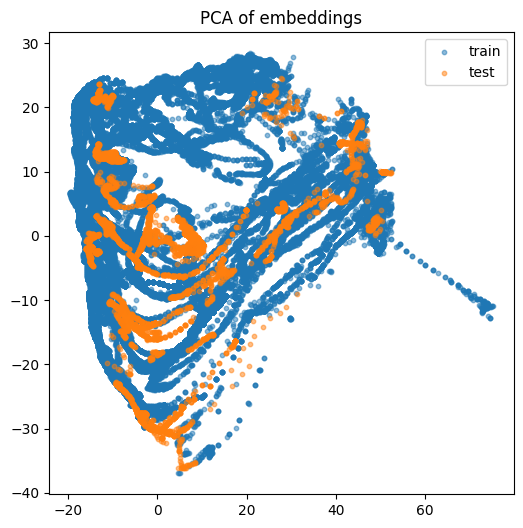

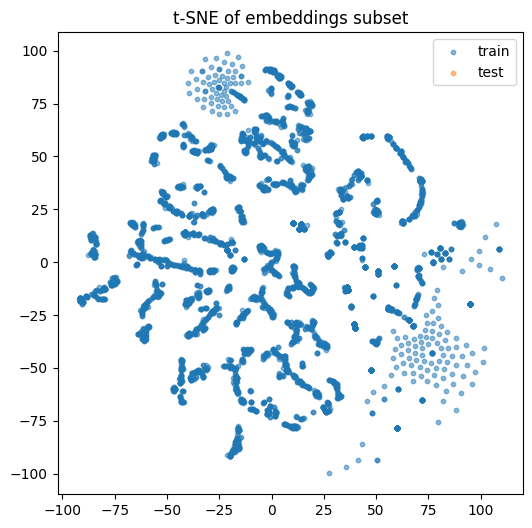

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,train_corr,test_corr
0,0.127771,-0.001185
1,0.137023,-0.025685
2,0.111223,-0.035238
3,0.037898,0.060579
4,-0.003531,-0.089207


In [118]:
emb_np = features_tensor.numpy().reshape(features_tensor.size(0), -1)
train_emb = emb_np[~global_test_mask_np]
test_emb  = emb_np[ global_test_mask_np]
train_y   = targets_np[~global_test_mask_np]
test_y    = targets_np[ global_test_mask_np]

ks_results = []
for dim in range(train_emb.shape[1]):
    stat, pval = ks_2samp(train_emb[:, dim], test_emb[:, dim])
    ks_results.append((dim, float(stat), float(pval)))
ks_df = pd.DataFrame(ks_results, columns=['dim','ks_stat','p_value'])
print("KS-test per feature dimension:")
display(ks_df.sort_values('p_value').head(10))

# 2. Compare target distributions
stat_y, pval_y = ks_2samp(train_y, test_y)
print(f"Target KS-test: stat={stat_y:.3f}, p={pval_y:.3f}")

# 3. PCA visualization
sc = StandardScaler()
emb_scaled = sc.fit_transform(np.vstack([train_emb, test_emb]))
pca = PCA(n_components=2).fit_transform(emb_scaled)
labels = ['train'] * len(train_emb) + ['test'] * len(test_emb)
df_pca = pd.DataFrame(pca, columns=['PC1','PC2'])
df_pca['set'] = labels
plt.figure(figsize=(6,6))
for label in ['train','test']:
    subset = df_pca[df_pca['set']==label]
    plt.scatter(subset.PC1, subset.PC2, label=label, alpha=0.5, s=10)
plt.legend(); plt.title("PCA of embeddings"); plt.show()

# 4. TSNE visualization (optional, slower)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(emb_scaled[:5000])  # subset for speed
labels_sub = labels[:5000]
df_tsne = pd.DataFrame(tsne_proj, columns=['Dim1','Dim2'])
df_tsne['set'] = labels_sub
plt.figure(figsize=(6,6))
for label in ['train','test']:
    subset = df_tsne[df_tsne['set']==label]
    plt.scatter(subset.Dim1, subset.Dim2, label=label, alpha=0.5, s=10)
plt.legend(); plt.title("t-SNE of embeddings subset"); plt.show()

# 5. Correlation of features with target in train vs test
corr_train = pd.DataFrame(train_emb).corrwith(pd.Series(train_y))
corr_test  = pd.DataFrame(test_emb).corrwith(pd.Series(test_y))
corr_df = pd.DataFrame({'train_corr': corr_train, 'test_corr': corr_test})
display(corr_df.head())